In [1]:
import pandas as pd
df_glass = pd.read_csv('glass (1).csv')
df_glass

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type
0,1.52101,13.64,4.49,1.10,71.78,0.06,8.75,0.00,0.0,1
1,1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0.00,0.0,1
2,1.51618,13.53,3.55,1.54,72.99,0.39,7.78,0.00,0.0,1
3,1.51766,13.21,3.69,1.29,72.61,0.57,8.22,0.00,0.0,1
4,1.51742,13.27,3.62,1.24,73.08,0.55,8.07,0.00,0.0,1
...,...,...,...,...,...,...,...,...,...,...
209,1.51623,14.14,0.00,2.88,72.61,0.08,9.18,1.06,0.0,7
210,1.51685,14.92,0.00,1.99,73.06,0.00,8.40,1.59,0.0,7
211,1.52065,14.36,0.00,2.02,73.42,0.00,8.44,1.64,0.0,7
212,1.51651,14.38,0.00,1.94,73.61,0.00,8.48,1.57,0.0,7


In [2]:
df_glass.isnull().sum()

RI      0
Na      0
Mg      0
Al      0
Si      0
K       0
Ca      0
Ba      0
Fe      0
Type    0
dtype: int64

In [3]:
df_glass.isna().sum()

RI      0
Na      0
Mg      0
Al      0
Si      0
K       0
Ca      0
Ba      0
Fe      0
Type    0
dtype: int64

In [4]:
df_glass[df_glass.duplicated()]

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type
39,1.52213,14.21,3.82,0.47,71.77,0.11,9.57,0.0,0.0,1


I am gonna drop the duplicat

In [5]:
df_glass.drop_duplicates(keep='last',inplace=True)

checking

In [7]:
df_glass.duplicated().sum()

0

In [8]:
# data is clean now
df_glass.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 213 entries, 0 to 213
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   RI      213 non-null    float64
 1   Na      213 non-null    float64
 2   Mg      213 non-null    float64
 3   Al      213 non-null    float64
 4   Si      213 non-null    float64
 5   K       213 non-null    float64
 6   Ca      213 non-null    float64
 7   Ba      213 non-null    float64
 8   Fe      213 non-null    float64
 9   Type    213 non-null    int64  
dtypes: float64(9), int64(1)
memory usage: 18.3 KB


In [9]:
df_glass.columns

Index(['RI', 'Na', 'Mg', 'Al', 'Si', 'K', 'Ca', 'Ba', 'Fe', 'Type'], dtype='object')

I am gonna rename the columns to understand more.

In [10]:
df_glass.rename(columns = {'RI':'RI/Refractive index', 'Na':'Na/Sodium', 'Mg': 'MG/Magnesium', 'Al': 'Al/Aluminum', 'Si': 'Si/Silicon', 'K':'K/Potassium', 'Ca':'Ca/Calcium','Ba': 'Ba/Barium', 'Fe': 'Fe/Iron' }, inplace = True)
df_glass

,RI/Refractive index,Na/Sodium,MG/Magnesium,Al/Aluminum,Si/Silicon,K/Potassium,Ca/Calcium,Ba/Barium,Fe/Iron,Type
0,1.52101,13.64,4.49,1.10,71.78,0.06,8.75,0.00,0.0,1
1,1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0.00,0.0,1
2,1.51618,13.53,3.55,1.54,72.99,0.39,7.78,0.00,0.0,1
3,1.51766,13.21,3.69,1.29,72.61,0.57,8.22,0.00,0.0,1
4,1.51742,13.27,3.62,1.24,73.08,0.55,8.07,0.00,0.0,1
...,...,...,...,...,...,...,...,...,...,...
209,1.51623,14.14,0.00,2.88,72.61,0.08,9.18,1.06,0.0,7
210,1.51685,14.92,0.00,1.99,73.06,0.00,8.40,1.59,0.0,7
211,1.52065,14.36,0.00,2.02,73.42,0.00,8.44,1.64,0.0,7
212,1.51651,14.38,0.00,1.94,73.61,0.00,8.48,1.57,0.0,7


It is necessary to determine which class the glass sample belongs to

There are seven types of glass listed: they are :

- Class 1: building windows(float processed)
- Class 2: biulding windows(non-float processed)
- Class 3: vehicle windows(float processed)
- Class 4: vehicle windows(non-flaot processed)
- Class 5: containers
- Class 6: tableware
- Class 7: headlamps

In [11]:
df_glass.describe()

,RI/Refractive index,Na/Sodium,MG/Magnesium,Al/Aluminum,Si/Silicon,K/Potassium,Ca/Calcium,Ba/Barium,Fe/Iron,Type
count,213.000000,213.000000,213.000000,213.000000,213.000000,213.000000,213.000000,213.000000,213.000000,213.000000
mean,1.518348,13.404085,2.679202,1.449484,72.655070,0.498873,8.954085,0.175869,0.057277,2.788732
std,0.003033,0.816662,1.443691,0.495925,0.773998,0.653185,1.425882,0.498245,0.097589,2.105130
min,1.511150,10.730000,0.000000,0.290000,69.810000,0.000000,5.430000,0.000000,0.000000,1.000000
25%,1.516520,12.900000,2.090000,1.190000,72.280000,0.130000,8.240000,0.000000,0.000000,1.000000
50%,1.517680,13.300000,3.480000,1.360000,72.790000,0.560000,8.600000,0.000000,0.000000,2.000000
75%,1.519150,13.810000,3.600000,1.630000,73.090000,0.610000,9.150000,0.000000,0.100000,3.000000
max,1.533930,17.380000,4.490000,3.500000,75.410000,6.210000,16.190000,3.150000,0.510000,7.000000


we can see in the plot hist some of them are not normalization distribution. when we fit it into the model our data probably will use standarstzation (.fit_transform)

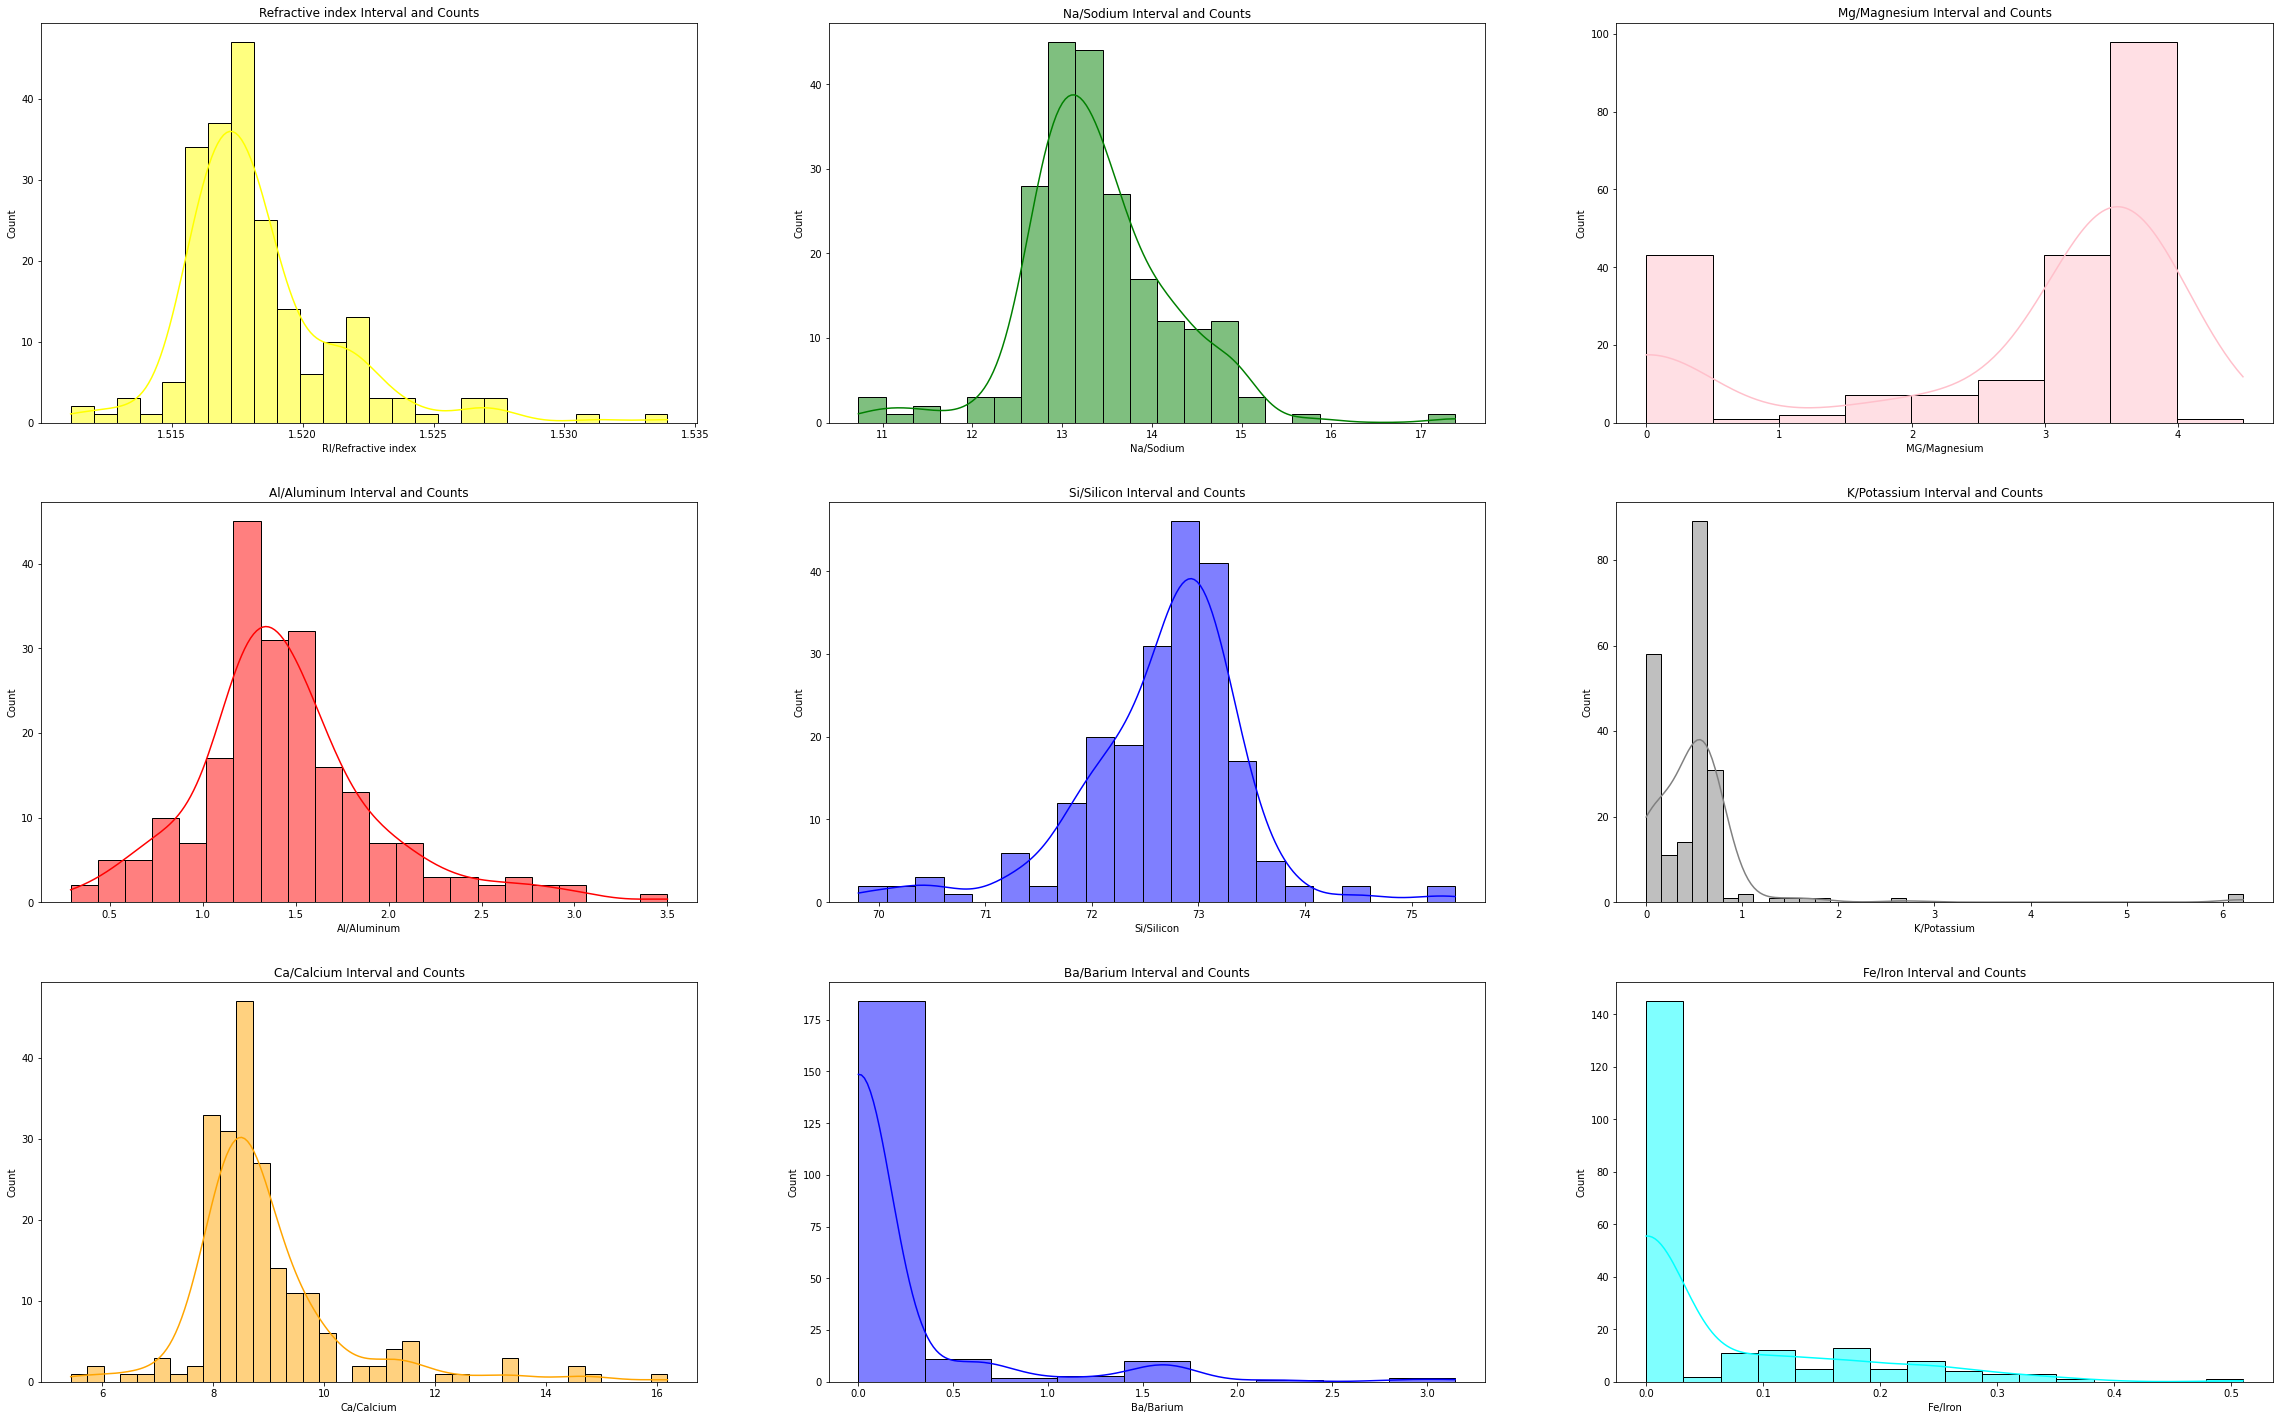

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(40,25))
plt.subplot(3,3,1)
sns.histplot(df_glass['RI/Refractive index'],color = 'yellow',kde = True).set_title('Refractive index Interval and Counts')
plt.subplot(3,3,2)
sns.histplot(df_glass['Na/Sodium'],color = 'green',kde = True).set_title('Na/Sodium Interval and Counts')
plt.subplot(3,3,3)
sns.histplot(df_glass['MG/Magnesium'],kde = True,color = 'pink',).set_title('Mg/Magnesium Interval and Counts')
plt.subplot(3,3,4)
sns.histplot(df_glass['Al/Aluminum'],kde = True,color = 'red').set_title('Al/Aluminum Interval and Counts')
plt.subplot(3,3,5)
sns.histplot(df_glass['Si/Silicon'],color = 'blue',kde = True).set_title('Si/Silicon Interval and Counts')
plt.subplot(3,3,6)
sns.histplot(df_glass['K/Potassium'],color = 'grey',kde = True).set_title('K/Potassium Interval and Counts')
plt.subplot(3,3,7)
sns.histplot(df_glass['Ca/Calcium'],color = 'orange',kde = True).set_title('Ca/Calcium Interval and Counts')
plt.subplot(3,3,8)
sns.histplot(df_glass['Ba/Barium'],color = 'blue',kde = True).set_title('Ba/Barium Interval and Counts')
plt.subplot(3,3,9)
sns.histplot(df_glass['Fe/Iron'],color = 'cyan',kde = True).set_title('Fe/Iron Interval and Counts')
plt.show()

,RI/Refractive index,Na/Sodium,MG/Magnesium,Al/Aluminum,Si/Silicon,K/Potassium,Ca/Calcium,Ba/Barium,Fe/Iron,Type
RI/Refractive index,1.000000,-0.198802,-0.127526,-0.400973,-0.539000,-0.287645,0.811183,0.001679,0.147083,-0.160140
Na/Sodium,-0.198802,1.000000,-0.278420,0.167735,-0.064885,-0.264158,-0.278194,0.329080,-0.239374,0.508837
MG/Magnesium,-0.127526,-0.278420,1.000000,-0.479575,-0.162437,0.007617,-0.446197,-0.491818,0.085426,-0.744195
Al/Aluminum,-0.400973,0.167735,-0.479575,1.000000,-0.016195,0.323683,-0.258068,0.480642,-0.080583,0.597432
Si/Silicon,-0.539000,-0.064885,-0.162437,-0.016195,1.000000,-0.197281,-0.207145,-0.104389,-0.097717,0.147725
K/Potassium,-0.287645,-0.264158,0.007617,0.323683,-0.197281,1.000000,-0.317032,-0.043653,-0.009372,-0.012455
Ca/Calcium,0.811183,-0.278194,-0.446197,-0.258068,-0.207145,-0.317032,1.000000,-0.112208,0.126314,0.002677
Ba/Barium,0.001679,0.329080,-0.491818,0.480642,-0.104389,-0.043653,-0.112208,1.000000,-0.059729,0.574896
Fe/Iron,0.147083,-0.239374,0.085426,-0.080583,-0.097717,-0.009372,0.126314,-0.059729,1.000000,-0.191090
Type,-0.160140,0.508837,-0.744195,0.597432,0.147725,-0.012455,0.002677,0.574896,-0.191090,1.000000


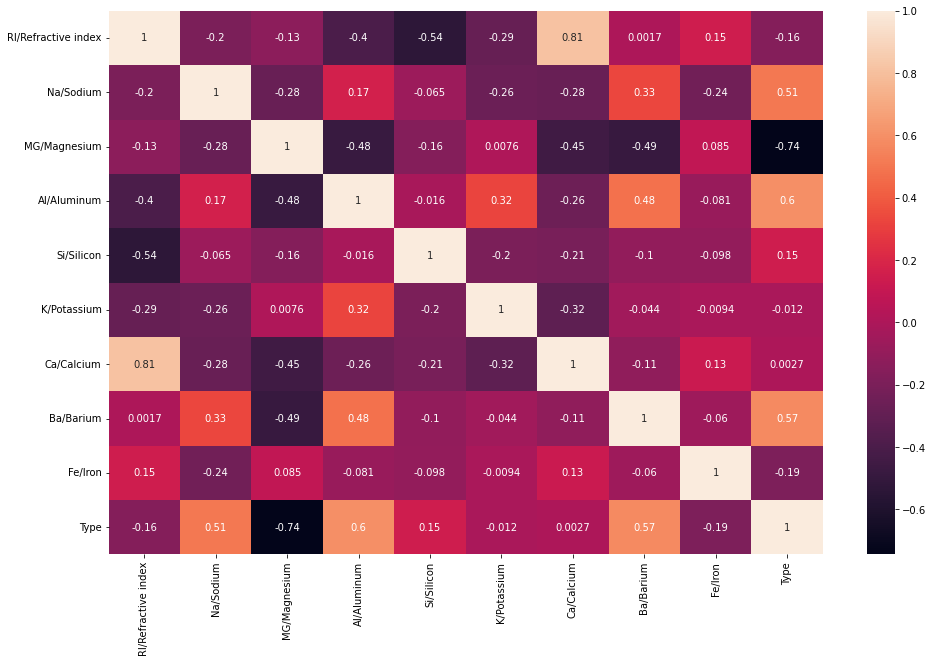

In [14]:
import seaborn as sns
corr_matrix = df_glass.corr()
plt.figure(figsize=(16,10))
sns.heatmap(corr_matrix,annot=True)
corr_matrix

I did the output plot, to see output imbalanced or no 
I think output imbalanced.

<AxesSubplot:xlabel='Type', ylabel='count'>

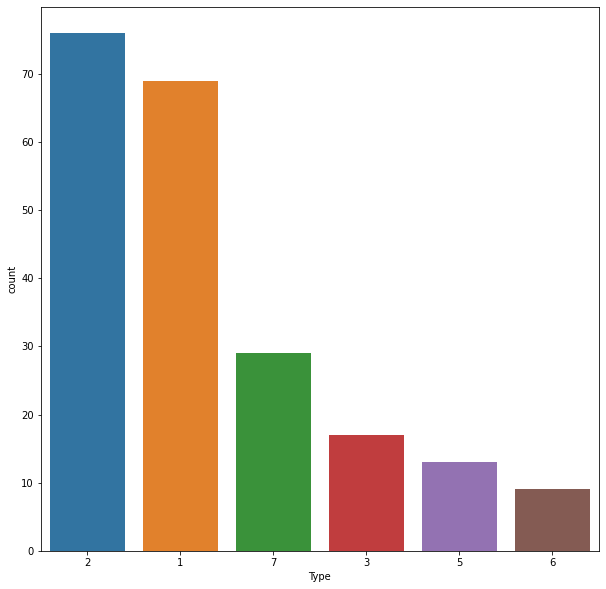

In [15]:
plt.figure(figsize=(10,10))
sns.countplot(x='Type', data=df_glass, order=df_glass['Type'].value_counts().index)